In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets as d, models, transforms as t
from torch.utils.data import DataLoader
import csv

In [2]:
torch.manual_seed(1234)


In [3]:
batch_size = 64

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

transforms = {
    'train': t.Compose([#t.RandomEqualize(p=1),
                        t.RandomHorizontalFlip(),
                        t.RandomResizedCrop(224),
                        t.RandomRotation(10),
                        t.ToTensor(),
                        t.Normalize(mean, std)]),
    'val_test': t.Compose([#t.RandomEqualize(p=1),
                           t.Resize(255),
                           t.CenterCrop(224),
                           t.ToTensor(),
                           t.Normalize(mean, std)])
}

datasets = {
    'train': d.ImageFolder('model_images copy/train', transform=transforms['train']),
    'valid': d.ImageFolder('model_images copy/valid', transform=transforms['val_test']),
    'test': d.ImageFolder('model_images copy/test', transform=transforms['val_test'])
}

loaders = {
    'train': DataLoader(datasets['train'], batch_size=batch_size, shuffle=True),
    'valid': DataLoader(datasets['valid'], batch_size=batch_size),
    'test': DataLoader(datasets['test'], batch_size=batch_size)
}

In [4]:
def imshow(image, ax=None):
    image = image.numpy().transpose((1, 2, 0))
    image = image * std + mean
    image = np.clip(image, 0, 1)
    ax.imshow(image) if ax else plt.imshow(image)

(torch.Size([3, 224, 224]), torch.Size([64]))

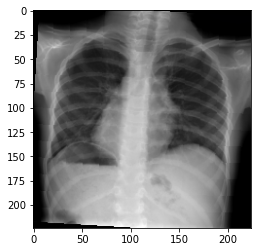

In [5]:
img, _ = next(iter(loaders['train']))
imshow(img[0])
img[0].shape,_.shape

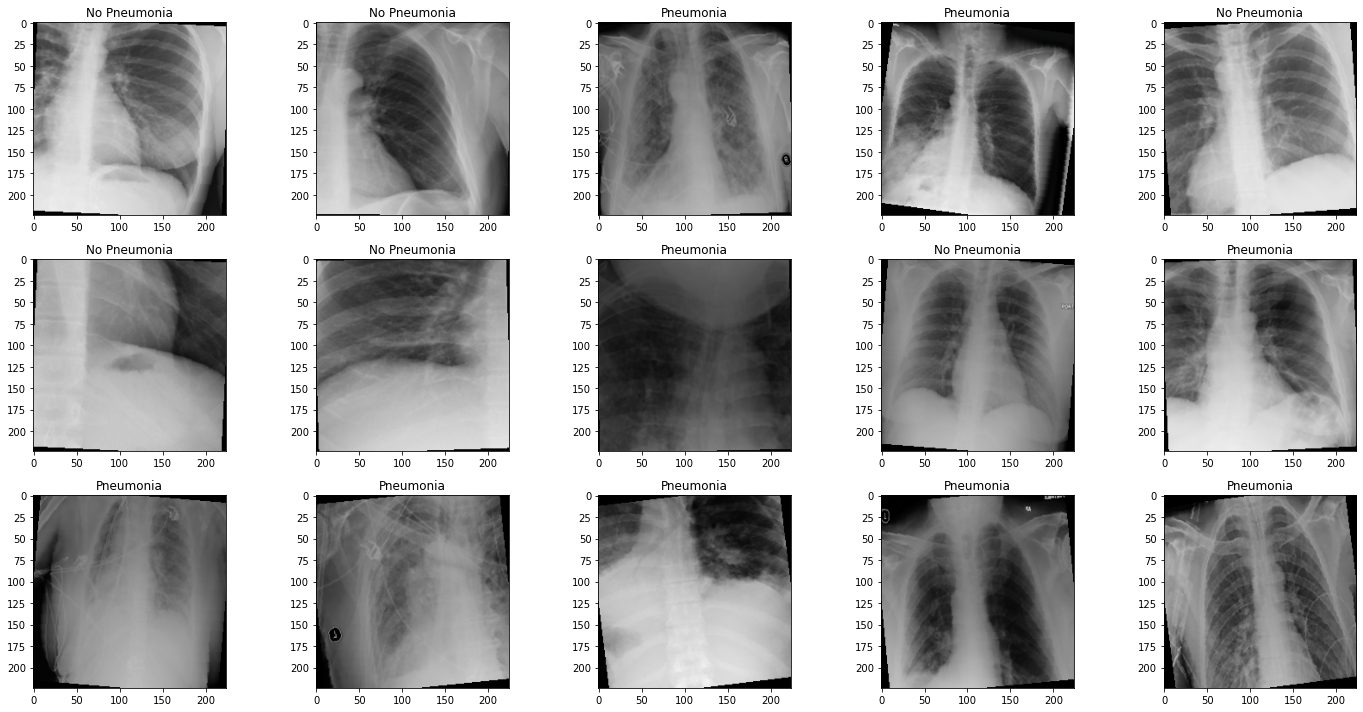

In [6]:
classes = datasets['train'].classes
images, labels = next(iter(loaders['train']))

fig, axes = plt.subplots(3, 5, figsize=(20, 10))
axes = axes.flatten()

for i, ax in enumerate(axes):
    imshow(images[i], ax)
    ax.set_title('Pneumonia' if int(classes[labels[i]]) else 'No Pneumonia')

plt.tight_layout()

### Initialize use_cuda variable

In [7]:
use_cuda = torch.cuda.is_available()
use_cuda

True

In [8]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf
    losses=np.zeros((n_epochs,2))

    for epoch in range(n_epochs):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0

        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for data, target in loaders['train']:
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda().unsqueeze(1).float()

            optimizer.zero_grad()
            out = model(data)
            loss = criterion(out, target)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()

        ######################
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for data, target in loaders['valid']:
            with torch.no_grad():
                # move to GPU
                if use_cuda:
                    data, target = data.cuda(), target.cuda().unsqueeze(1).float()

                val_out = model(data)
                loss = criterion(val_out, target)
                valid_loss += loss.item()

        train_loss /= len(loaders['train'])
        valid_loss /= len(loaders['valid'])
        losses[epoch]=(train_loss,valid_loss)

        # print training/validation statistics
        print(
            f'Epoch: {epoch+1} \tTraining Loss: {train_loss:.6f} \tValidation Loss: {valid_loss:.6f}')

        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ... Model saved ...')
            valid_loss_min = valid_loss
            torch.save(model.state_dict(), save_path)

    return model, losses

In [9]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    y_true = np.array([])
    y_pred = np.array([])

    # set the module to evaluation mode
    model.eval()

    for data, target in loaders['test']:
        # move to GPU
        with torch.no_grad():
            if use_cuda:
                data, target = data.cuda(), target.cuda().unsqueeze(1).float()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # update average test loss
            test_loss += loss.item()

            output = torch.sigmoid(output)
            y_true = np.append(y_true, target.cpu().numpy())
            y_pred = np.append(y_pred, output.cpu().numpy())

            
    test_loss /= len(loaders['test'])

    print(f'Test Loss: {test_loss:.6f}\n')

    return test_loss, y_true, y_pred

In [10]:
model = models.googlenet(pretrained=True)

model.fc = nn.Sequential(nn.Linear(model.fc.in_features, 128, bias=False),
                         nn.BatchNorm1d(128),
                         nn.ReLU(),
                         nn.Dropout(0.25),
                         nn.Linear(128, 1))

lr = 0.0001
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [11]:
# def weights_init_normal(m):
#     classname = m.__class__.__name__
#     # for every Linear layer in a model..
#     if classname.find('Linear') != -1:
#         # get the number of the inputs
#         n = m.in_features
#         y = (1.0 / np.sqrt(n))
#         m.weight.data.normal_(0, y)
#         # m.bias.data.fill_(0)

# model.apply(weights_init_normal)

In [12]:
if use_cuda:
    model = model.cuda()

epochs = 50
model, losses = train(epochs, loaders, model, optimizer, criterion, use_cuda, 'model4.pt')

model.load_state_dict(torch.load('model4.pt'))

Epoch: 1 	Training Loss: 0.600481 	Validation Loss: 0.591043
Validation loss decreased ... Model saved ...
Epoch: 2 	Training Loss: 0.514266 	Validation Loss: 0.333353
Validation loss decreased ... Model saved ...
Epoch: 3 	Training Loss: 0.497554 	Validation Loss: 0.367570
Epoch: 4 	Training Loss: 0.488786 	Validation Loss: 0.465577
Epoch: 5 	Training Loss: 0.472693 	Validation Loss: 0.392385
Epoch: 6 	Training Loss: 0.452823 	Validation Loss: 0.324480
Validation loss decreased ... Model saved ...
Epoch: 7 	Training Loss: 0.456486 	Validation Loss: 0.363205
Epoch: 8 	Training Loss: 0.454523 	Validation Loss: 0.359260
Epoch: 9 	Training Loss: 0.437983 	Validation Loss: 0.355612
Epoch: 10 	Training Loss: 0.447073 	Validation Loss: 0.637150
Epoch: 11 	Training Loss: 0.416410 	Validation Loss: 0.332136
Epoch: 12 	Training Loss: 0.424989 	Validation Loss: 0.397744
Epoch: 13 	Training Loss: 0.412797 	Validation Loss: 0.484766
Epoch: 14 	Training Loss: 0.401265 	Validation Loss: 0.538279
Epo

<All keys matched successfully>

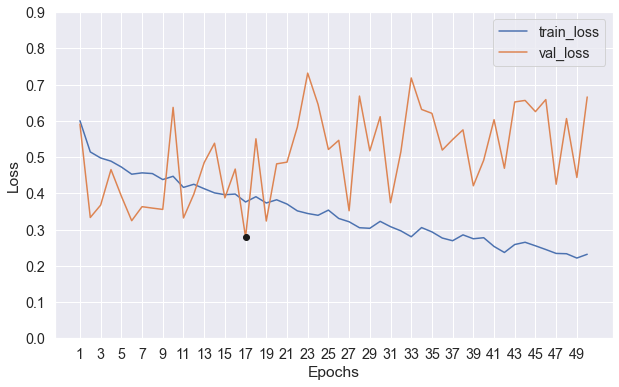

In [13]:
def plot_losses(losses):
    _,ax=plt.subplots(figsize=(10,6))
    ax.set(xlabel='Epochs',ylabel='Loss')
    ax.plot(range(1,epochs+1),losses[:,0],label='train_loss')
    ax.plot(range(1,epochs+1),losses[:,1],label='val_loss')
    ax.plot(np.argmin(losses[:, 1])+1, np.min(losses[:, 1]), marker='o', color='k', markersize=6) 
    ax.set_xticks(range(1, epochs+1, 2))
    ax.set_yticks(np.arange(0, np.max(losses[:, 1])+0.2, 0.1))
    ax.legend()

import seaborn as sns
sns.set_theme(font_scale=1.3)
plot_losses(losses)  

In [12]:
if use_cuda:
    model = model.cuda()
    
model.load_state_dict(torch.load('model4.pt'))
test_loss, y_true, y_pred = test(loaders, model, criterion, use_cuda)

Test Loss: 0.272242



In [39]:
# Graphs functions

from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, plot_precision_recall_curve, f1_score, confusion_matrix


def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    
    # Todo
    
    fig, ax = plt.subplots(1,1, figsize=(8,8))
    fpr, tpr, threshold = roc_curve(t_y, p_y)
    ax.plot(fpr, tpr, label='%s (AUC:%.2f)' % ('Pneumonia', auc(fpr, tpr)))
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black', label='Chance', alpha=.8)
    ax.legend()
    ax.set_xlabel('1 - Spicifity')
    ax.set_ylabel('Sensitivity')


def pr_curve(ground_truth, probability):
    
    fig, ax = plt.subplots(1,1, figsize=(8,8))
    precision, recall, threshold = precision_recall_curve(ground_truth, probability)
    ax.plot(recall, precision, label='%s (AP Score:%.2f)' % ('Pneumonia', average_precision_score(ground_truth, probability)))
    ax.legend()
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')


def cal_F1Score(precision, recall):
    f1_score = 2*(precision * recall)/(precision + recall)
    return f1_score


def plot_f1_score(valY, pred_Y):
    
    precision, recall, threshold = precision_recall_curve(valY, pred_Y)
    f1_scores = [cal_F1Score(precision[i], recall[i]) for i in range(len(threshold))]
    max_f1_score_idx = np.argmax(f1_scores)
    
    print('Max F1 Score and corresponding Precision, recall and Threshold\n')
    print('Precision: '+ str(precision[max_f1_score_idx]))
    print('Recall: '+ str(recall[max_f1_score_idx]))
    print('Threshold: '+ str(threshold[max_f1_score_idx]))
    print('F1 Score: ' + str(f1_scores[max_f1_score_idx]))
    
    plt.figure()
    plt.plot(threshold, f1_scores)
    plt.title("F1-Score vs Threshold")
    plt.xlabel("Epoch Number")
    plt.ylabel("F1-Score")
    plt.show()
    return threshold[max_f1_score_idx]

Max F1 Score and corresponding Precision, recall and Threshold

Precision: 0.5602409638554217
Recall: 0.4325581395348837
Threshold: 0.9351847171783447
F1 Score: 0.4881889763779527


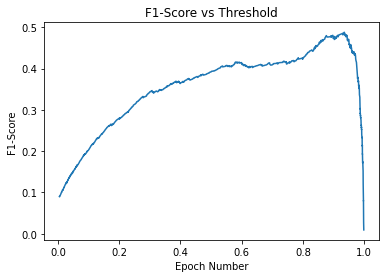

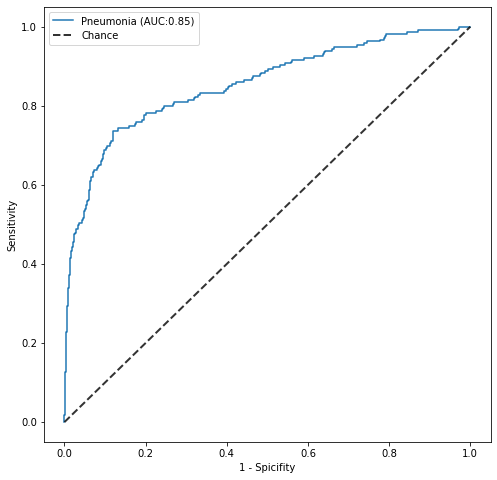

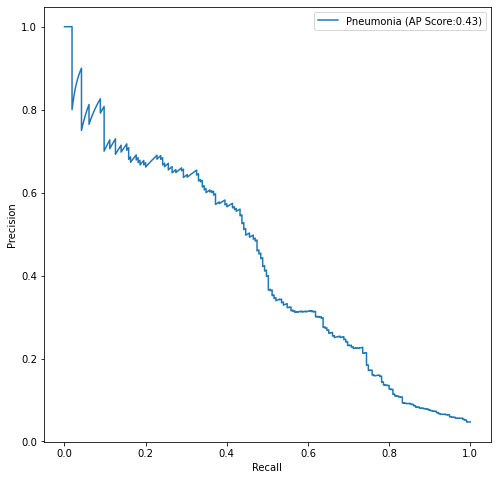

In [40]:
YOUR_THRESHOLD = plot_f1_score(y_true, y_pred)
plot_auc(y_true, y_pred)
pr_curve(y_true, y_pred)

In [17]:
def store_model_info(file_path, model_name, classifier, optimizer_name, lr, min_valid_loss, test_loss):
    with open(file_path, 'a') as f:

        classifier_info = '\n'.join(str(layer) for layer in classifier)

        row = [model_name, classifier_info, optimizer_name, lr, min_valid_loss, test_loss]
        # create the csv writer
        writer = csv.writer(f)

        # write a row to the csv file
        writer.writerow(row)

In [18]:
# min_valid_loss = min(losses[:, 1])

# store_model_info('try.csv', 'resnet101', model.fc, optimizer.__class__.__name__, lr, min_valid_loss, test_loss)

In [29]:
def calculate_statistics(target, pred, threshold):

    target, pred = torch.from_numpy(target), torch.from_numpy(pred)
    
    # convert output probabilities to predicted class
    pred = (torch.sigmoid(pred) > threshold).to(torch.float32)

    tp = (target * pred).sum()
    tn = ((1 - target) * (1 - pred)).sum().to(torch.float32)
    fp = ((1 - target) * pred).sum().to(torch.float32)
    fn = (target * (1 - pred)).sum().to(torch.float32)

    sensitivity = tp / (tp + fn)
    specifity = tn / (tn + fp)
    precision = tp / (tp + fp)
    f1_score = 2 * (sensitivity * precision) / (sensitivity + precision)

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * (tp + tn) / (tp + tn + fp + fn), (tp + tn), (tp + tn + fp + fn)))
    print(f'sensitivity = {sensitivity}')
    print(f'recall = {sensitivity}')
    print(f'specifity = {specifity}')
    print(f'precision = {precision}')
    print(f"f1 score = {f1_score}")
    print(f"tp={tp}, fn={fn}, tn={tn}, fp={fp}")

In [35]:
calculate_statistics(y_true, y_pred, 0.53)


Test Accuracy: 74% (3486/4685)
sensitivity = 0.8
recall = 0.8
specifity = 0.7413870096206665
precision = 0.12951807228915663
f1 score = 0.22294232015554113
tp=172.0, fn=43.0, tn=3314.0, fp=1156.0


In [36]:
test_dataset = {
    'test': d.ImageFolder('model_images/test', transform=transforms['val_test'])
}

test_loaders = {
    'test': DataLoader(test_dataset['test'], batch_size=batch_size)
}

In [41]:
test_loss, y_true, y_pred = test(test_loaders, model, criterion, use_cuda)

Test Loss: 0.357839



Max F1 Score and corresponding Precision, recall and Threshold

Precision: 0.5745412844036697
Recall: 0.8294701986754967
Threshold: 0.27218765020370483
F1 Score: 0.6788617886178862


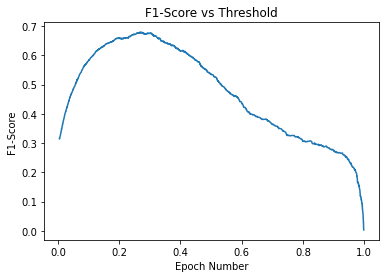

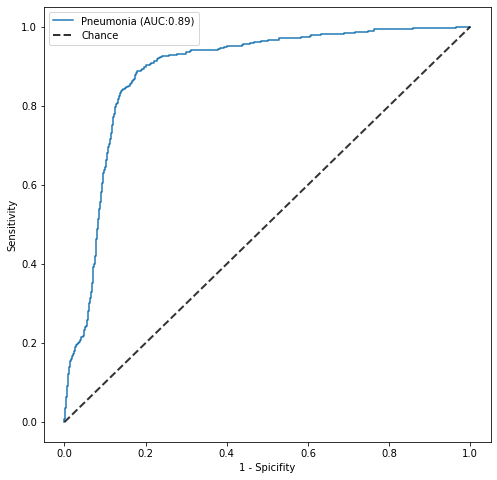

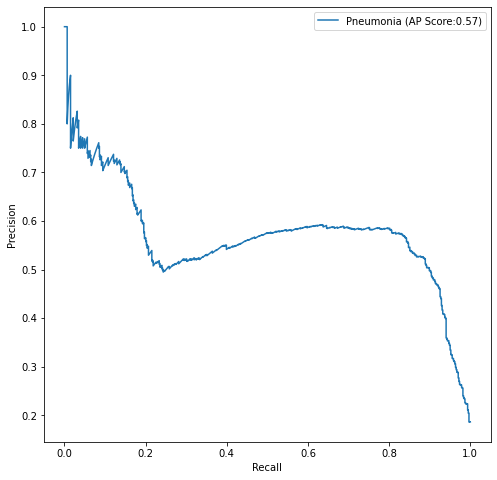

In [42]:
YOUR_THRESHOLD = plot_f1_score(y_true, y_pred)
plot_auc(y_true, y_pred)
pr_curve(y_true, y_pred)

In [47]:
calculate_statistics(y_true, y_pred, 0.55)


Test Accuracy: 83% (2779/3330)
sensitivity = 0.8791390728476821
recall = 0.8791390728476821
specifity = 0.8246514797210693
precision = 0.5262636273538157
f1 score = 0.6584004959702419
tp=531.0, fn=73.0, tn=2248.0, fp=478.0


In [ ]:
import os


In [ ]:
model.cpu()
model.eval()
with torch.no_grad():
    for img_path in os.listdir('model_images\\valid\\1'):
        image_test = transforms['val_test'](Image.open(
            f'model_images\\valid\\1\\{img_path}').convert('RGB'))
        print(torch.sigmoid(model(image_test.unsqueeze(0))) > 0.2)


tensor([[True]])
tensor([[False]])
tensor([[True]])
tensor([[True]])
tensor([[True]])
tensor([[True]])
tensor([[False]])
tensor([[True]])
tensor([[True]])
tensor([[False]])
tensor([[True]])
tensor([[True]])
tensor([[True]])
tensor([[False]])
tensor([[False]])
tensor([[False]])
tensor([[True]])
tensor([[False]])
tensor([[True]])
tensor([[True]])
tensor([[False]])
tensor([[True]])
tensor([[False]])
tensor([[False]])
tensor([[True]])
tensor([[True]])
tensor([[True]])
tensor([[True]])
tensor([[False]])
tensor([[False]])
tensor([[True]])
tensor([[True]])


In [ ]:
torch.sigmoid(model(image_test.unsqueeze(0)))


tensor([[0.6525]], grad_fn=<SigmoidBackward>)

In [ ]:
def predict(img_path):
    with torch.no_grad():
        img = transforms['val_test'](Image.open(
            img_path).convert('RGB')).unsqueeze(0)

        model.load_state_dict(torch.load('model.pt'))
        model.eval()
        preds = torch.sigmoid(model.forward(img))
        return preds


# test on a sample image
predict('model_images\\test\\0\\00009866_000.png')


tensor([[0.0066]])

Pneumonia ... Pneumonia Possibility = 69.98%


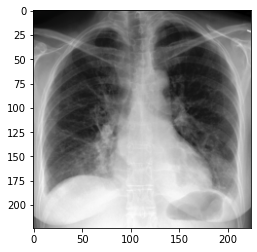

In [ ]:
def predict_show(img_path):
    preds = predict(img_path)
    img = transforms['val_test'](Image.open(img_path).convert('RGB'))
    img = img.numpy().transpose(1, 2, 0)*std+mean
    plt.imshow(img.clip(0, 1))
    print(f"{'Pneumonia' if preds > 0.2 else 'Normal'} ... Pneumonia Possibility = {preds.item()*100:.2f}%")


# test on a sample image
predict_show('model_images\\test\\1\\00016825_000.png')  # Positive
